<a href="https://colab.research.google.com/github/davidgvad/Main_Projects/blob/main/Image_Identifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')  # Mount Google Drive to access files

Mounted at /content/drive


In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow_datasets as tfds
import pathlib


In [ ]:
# Specify the directory where the image dataset is located
data_dir = '/content/drive/MyDrive/museum grant new'

# Create a dataset builder for images in the specified directory
builder = tfds.ImageFolder(data_dir)
print(builder.info)  # Print information about the dataset

# Load the dataset as a tf.data.Dataset object with shuffled files
ds = builder.as_dataset(shuffle_files=True)

tfds.core.DatasetInfo(
    name='image_folder',
    full_name='image_folder/1.0.0',
    description="""
    Generic image classification dataset.
    """,
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    data_dir='/root/tensorflow_datasets/image_folder/1.0.0',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=Unknown size,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=0),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
    },
    citation="""""",
)


In [ ]:
# Define parameters for batch size and image dimensions
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
# Create a training dataset from the directory with a validation split
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.05,  # 5% of data used for validation
  subset="training",      # Specify subset as training data
  seed=123,               # Seed for reproducibility
  image_size=(img_height, img_width),  # Resize images to specified dimensions
  batch_size=batch_size   # Number of samples per batch
)

Found 9420 files belonging to 48 classes.
Using 8949 files for training.


In [ ]:
# Create a validation dataset from the directory with a different validation split
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.25,  # 25% of data used for validation
  subset="validation",    # Specify subset as validation data
  seed=123,               # Seed for reproducibility
  image_size=(img_height, img_width),  # Resize images to specified dimensions
  batch_size=batch_size   # Number of samples per batch
)

Found 9420 files belonging to 48 classes.
Using 2355 files for validation.


In [ ]:
# Get the class names from the training dataset
class_names = train_ds.class_names
print(len(class_names))  # Print the number of classes

48


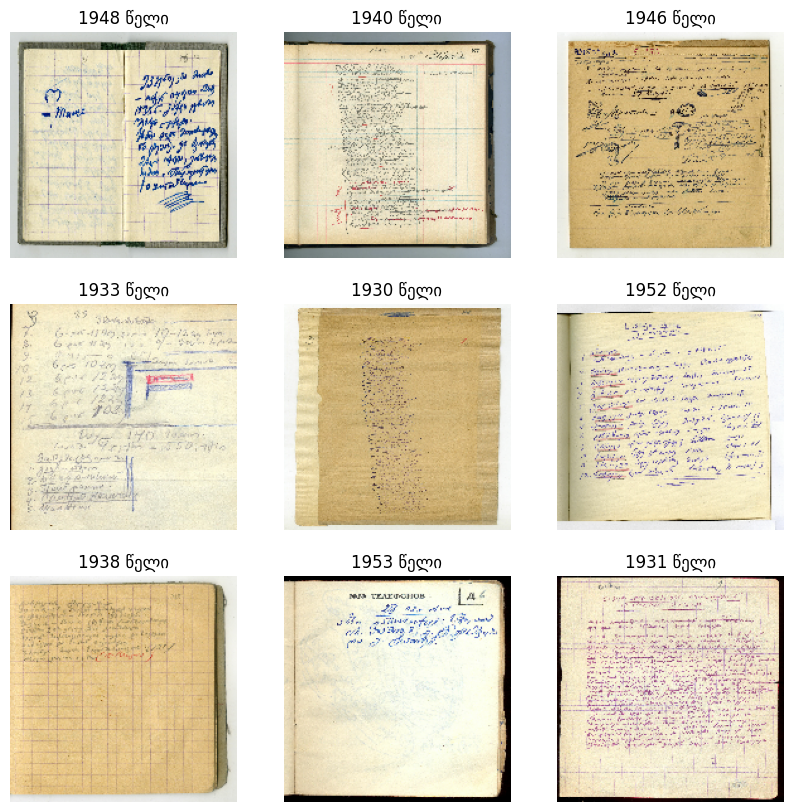

In [ ]:
# Visualize some images from the training dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):  # Take one batch from the training dataset
     for i in range(9):  # Display the first 9 images
       ax = plt.subplot(3, 3, i + 1)
       plt.imshow(images[i].numpy().astype("uint8"))  # Display the image
       plt.title(class_names[labels[i]])  # Show the class name as the title
       plt.axis("off")  # Hide axis

In [ ]:
# Print the shape of one batch of images and labels
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)  # Shape of image batch
    print(labels_batch.shape)  # Shape of label batch
    break  # Exit after the first batch

(32, 180, 180, 3)
(32,)


In [ ]:
# Create a normalization layer to scale pixel values between 0 and 1
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
# Apply the normalization layer to the training dataset
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

# Retrieve one batch from the normalized dataset
image_batch, labels_batch = next(iter(normalized_ds))

# Get the first image from the batch
first_image = image_batch[0]

# Print the minimum and maximum pixel values of the first image
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
# Set up automatic tuning for performance optimization
AUTOTUNE = tf.data.AUTOTUNE

# Cache and prefetch the training dataset for improved performance
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Cache and prefetch the validation dataset for improved performance
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Define data augmentation layers to prevent overfitting
data_augmentation = keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),  # Randomly flip images horizontally and vertically
])

In [ ]:
# Specify the number of classes for classification
num_classes = 48

# Build the convolutional neural network model
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),  # Normalize pixel values
  data_augmentation,                  # Apply data augmentation
  tf.keras.layers.Conv2D(32, (3,3), activation='relu'),  # First convolutional layer with 32 filters
  tf.keras.layers.MaxPooling2D((2,2)),                   # First max pooling layer
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),  # Second convolutional layer with 64 filters
  tf.keras.layers.MaxPooling2D((2,2)),                   # Second max pooling layer
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'), # Third convolutional layer with 128 filters
  tf.keras.layers.MaxPooling2D((2,2)),                   # Third max pooling layer
  tf.keras.layers.Flatten(),                             # Flatten the feature maps
  tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),  # Fully connected layer with L2 regularization
  # tf.keras.layers.Dropout(0.1),  # Dropout layer to prevent overfitting (commented out)
  tf.keras.layers.Dense(num_classes),  # Output layer with units equal to the number of classes
])

In [ ]:
# Compile the model with optimizer, loss function, and evaluation metrics
model.compile(
  optimizer='adam',  # Optimization algorithm
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # Loss function for multi-class classification
  # loss='sparse_categorical_crossentropy',  # Alternative way to specify loss function (commented out)
  metrics=['accuracy']  # Metric to evaluate during training and testing
)

In [ ]:
# Train the model using the training dataset and validate using the validation dataset
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=30  # Number of epochs to train the model
)

Epoch 1/30
280/280 [==============================] - 1862s 7s/step - loss: 3.5731 - accuracy: 0.1022 - val_loss: 3.2244 - val_accuracy: 0.1609
Epoch 2/30
280/280 [==============================] - 379s 1s/step - loss: 3.1482 - accuracy: 0.1969 - val_loss: 2.9461 - val_accuracy: 0.2450
Epoch 3/30
280/280 [==============================] - 383s 1s/step - loss: 2.9301 - accuracy: 0.2451 - val_loss: 2.7698 - val_accuracy: 0.2896
Epoch 4/30
280/280 [==============================] - 396s 1s/step - loss: 2.7660 - accuracy: 0.2906 - val_loss: 2.5995 - val_accuracy: 0.3448
Epoch 5/30
280/280 [==============================] - 383s 1s/step - loss: 2.6238 - accuracy: 0.3365 - val_loss: 2.4393 - val_accuracy: 0.3792
Epoch 6/30
280/280 [==============================] - 401s 1s/step - loss: 2.5367 - accuracy: 0.3586 - val_loss: 2.3731 - val_accuracy: 0.4093
Epoch 7/30
280/280 [==============================] - 396s 1s/step - loss: 2.4627 - accuracy: 0.3883 - val_loss: 2.2629 - val_accuracy: 0.459

In [ ]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# epochs=30
# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs_range = range(epochs)

# plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

In [ ]:
import torch
from torchvision import datasets, models, transforms
from os.path import exists
# List the contents of a directory in Google Drive
print(os.listdir('drive/MyDrive/latestmodel316'))

# Load a pre-trained model from Google Drive
model = tf.keras.models.load_model('drive/MyDrive/latestmodel317')

# Print a summary of the model architecture
model.summary()


['variables', 'assets', 'saved_model.pb', 'fingerprint.pb', 'keras_metadata.pb']
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43,

In [ ]:
# Zip the model directory for downloading
!zip -r ./content/drive/MyDrive/Models/mymodel.zip ./content/drive/MyDrive/Models/mymodel

  adding: content/drive/MyDrive/Models/mymodel/ (stored 0%)
  adding: content/drive/MyDrive/Models/mymodel/keras_metadata.pb (deflated 92%)
  adding: content/drive/MyDrive/Models/mymodel/saved_model.pb (deflated 88%)
  adding: content/drive/MyDrive/Models/mymodel/fingerprint.pb (stored 0%)
  adding: content/drive/MyDrive/Models/mymodel/variables/ (stored 0%)
  adding: content/drive/MyDrive/Models/mymodel/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: content/drive/MyDrive/Models/mymodel/variables/variables.index (deflated 63%)
  adding: content/drive/MyDrive/Models/mymodel/assets/ (stored 0%)


In [ ]:
from google.colab import files
# Download the zipped model file
files.download("content/drive/MyDrive/Models/mymodel")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Re-compile the model after loading (necessary if custom objects are used)
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.preprocessing import image

# Create a list of class labels representing years, excluding specific years
class_labels = [i for i in range(1907,1959)]
class_labels.remove(1916)  # Remove the year 1916
class_labels.remove(1917)  # Remove the year 1917
class_labels.remove(1918)  # Remove the year 1918
class_labels.remove(1920)  # Remove the year 1920
resultDict = {}  # Initialize a dictionary to store results
print(class_labels)  # Print the list of class labels

# Initialize the result dictionary with filenames as keys
for file in os.listdir('drive/MyDrive/toCheck'):
  resultDict[file] = []

# Loop over each file in the directory to make predictions
for file in os.listdir('drive/MyDrive/toCheck'):
  # Load the image and resize it to match the input size of the model
  test_image = tf.keras.preprocessing.image.load_img('drive/MyDrive/toCheck/'+file, target_size = (180, 180))
  test_image = image.img_to_array(test_image)  # Convert the image to a NumPy array
  test_image = np.expand_dims(test_image, axis = 0)  # Expand dimensions to create a batch of size 1

  result = model.predict(test_image)  # Make a prediction using the model
  print(result)  # Print the raw prediction output

  ogList = result.tolist()[0]  # Convert the prediction to a list
  print(ogList)  # Print the list of prediction scores
  sortedListCopy = result.tolist()[0]  # Create a copy of the prediction list
  sortedListCopy.sort()  # Sort the list in ascending order
  bestThree = sortedListCopy[-3:]  # Get the top three prediction scores
  bestThree.reverse()  # Reverse the list to have the highest scores first
  for num in bestThree:
    resultDict[file].append(class_labels[ogList.index(num)])  # Map scores to class labels and store in resultDict

# Print the dictionary containing filenames and their top three predicted classes
print(resultDict)

# Determine the class with the highest prediction score
# MaxPosition = np.argmax(result)  # Get the index of the maximum prediction score
# prediction_label = class_labels[MaxPosition]  # Map the index to the corresponding class label
# print(prediction_label)  # Print the predicted class label

[1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915, 1919, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958]
1/1 [==============================] - 0s 332ms/step
[[ -3.7134004   -6.3926916   -5.787499    -9.125563    -0.99665636
   -4.1027226  -12.023231    -3.5206108   -1.2805104  -10.025498
   -5.738699    -6.0035653   -4.5739665   -5.114549    -2.6903887
   -4.456877    -2.7996795   -3.4339395   -3.1080143   -0.6379583
   -2.5616877   -1.6411915   -1.8954744   -1.1755427    0.16981703
   -2.7866576   -1.5397567   -3.5360594    1.1408231   -4.157875
   -1.5690637   -4.1845765   -2.4536405   -5.042571    -1.4830158
   -6.631689    -2.4841297   -2.8912458   -2.4779973   -1.7192682
   -0.7170142    1.2173183   -2.667375    -0.83491814  -0.709499
    0.18724564  -2.3732457   -0.9072344 ]]
[-3.713400363922119, -